In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/qb/3b9vthxj0yz71xs5y09fc8240000gn/T/ipykernel_26962/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date)


('2017-08-23',)


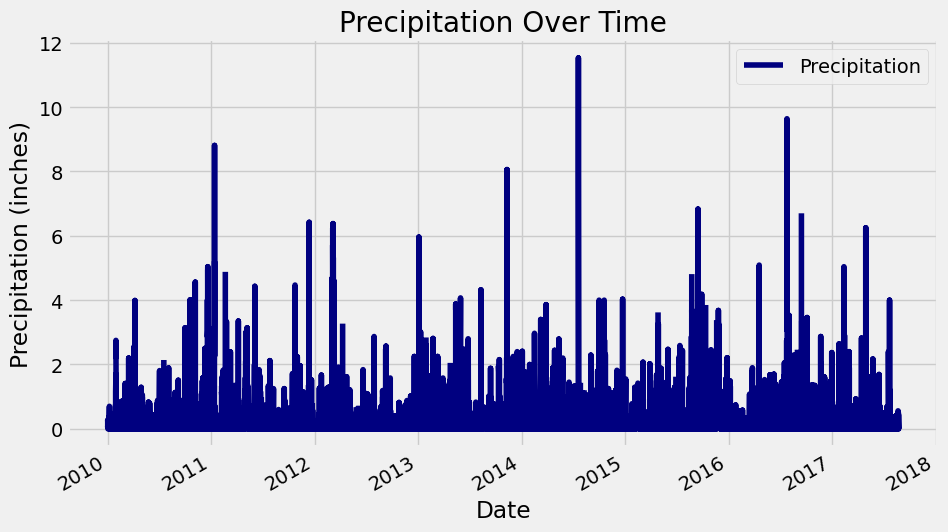

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert the date to a datetime object
date = dt.datetime.strptime(date, '%Y-%m-%d')
twelve_months = date - pd.DateOffset(months=12)

# Calculate the date one year from the last date in data set.
one_year = date + pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation= session.query(Measurement.date, Measurement.prcp).all()

# Save the query results as a Pandas DataFrame
df_precipitation = pd.DataFrame(precipitation, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df_precipitation['Date'] = pd.to_datetime(df_precipitation['Date'])
df_precipitation = df_precipitation.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df_precipitation.plot(x='Date', y='Precipitation', kind='line', figsize=(10,6), color='navy')
plt.title("Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = df_precipitation['Precipitation'].describe()
print(precipitation_summary)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(Station.id)).scalar()
print(stations)

9


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


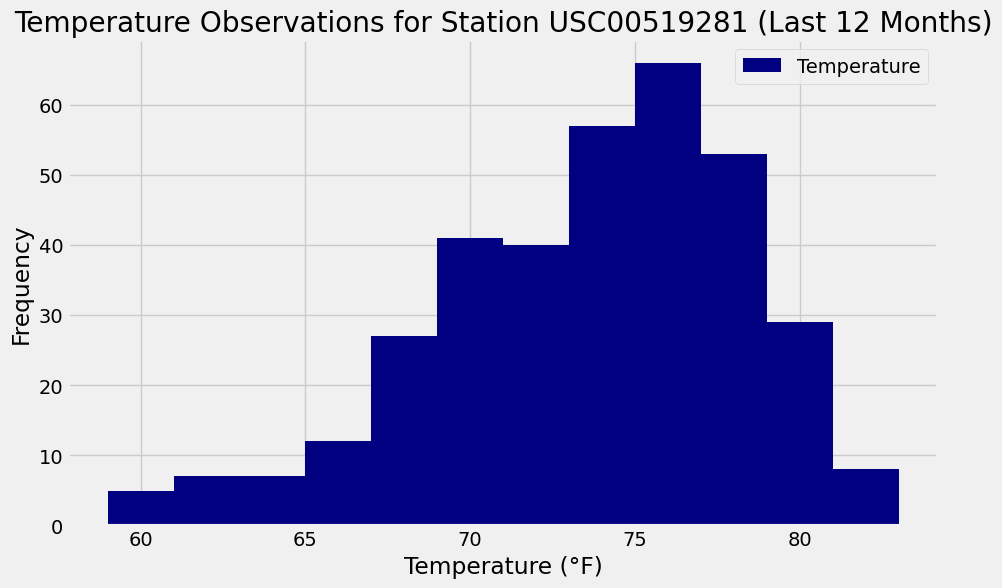

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = active_stations[0][0] 

date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert the date string to a datetime object
date = dt.datetime.strptime(date, '%Y-%m-%d')

# Calculate the date 12 months ago
twelve_months = date - pd.DateOffset(months=12)

# Convert the Timestamp to a string
twelve_months_str = twelve_months.strftime('%Y-%m-%d')

# Query the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= twelve_months_str).\
    all()

df_temperature = pd.DataFrame(temperature_data, columns=["Temperature"])

df_temperature.plot(kind='hist', bins=12, figsize=(10,6), color='navy')

plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()


# Close Session

In [36]:
# Close Session
session.close()

In [37]:
from flask import Flask, jsonify
import datetime as dt
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


In [38]:
# Set up the database engine to connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect the existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session to interact with the database
session = Session(engine)


/var/folders/qb/3b9vthxj0yz71xs5y09fc8240000gn/T/ipykernel_26962/2443620673.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [39]:
# Reflect the existing database into a new model
Base = automap_base()

# Reflect the tables from the database into our model
Base.prepare(engine, reflect=True)


/var/folders/qb/3b9vthxj0yz71xs5y09fc8240000gn/T/ipykernel_26962/1476456253.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [40]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [41]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import sessionmaker

Session = sessionmaker(bind=engine)

session = Session()


In [43]:
def precipitation():
    # Get the precipitation data for the last year
    results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= twelve_months).\
        order_by(Measurement.date).all()

    # Create a dictionary
    precipitation_data = {date: prcp for date, prcp in results}

    return jsonify(precipitation_data)

In [44]:
def stations():
    # Get all station data
    results = session.query(Station.station, Station.name).all()
    stations_data = [{"station": station, "name": name} for station, name in results]

    return jsonify(stations_data)

In [45]:
def start(start):
    # Query the temperature data from the start date to the end date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).all()

    # Return the results as a JSON response
    temperature_data = [{
        "min_temperature": results[0][0],
        "avg_temperature": results[0][1],
        "max_temperature": results[0][2]
    }]
    return jsonify(temperature_data)

In [46]:
def start_end(start, end):
    # Query the temperature data from the start date to the end date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()

    # Return the results as a JSON response
    temperature_data = [{
        "min_temperature": results[0][0],
        "avg_temperature": results[0][1],
        "max_temperature": results[0][2]
    }]
    return jsonify(temperature_data)